<a href="https://colab.research.google.com/github/01PrathamS/make_more/blob/main/batch_norm_make_more_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('make_more_names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [38]:
n_embd = 10 ## the dimensionality of the character embedding vectors
n_hidden = 200 ## the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(200, generator=g) * 0.01
W2 = torch.randn((200, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g)  * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12297


tensor(-0.0104) tensor(1.0051)
tensor(0.0025) tensor(3.1347)


(array([0.00060279, 0.00060279, 0.00060279, 0.00060279, 0.00060279,
        0.        , 0.00482231, 0.00180837, 0.00361673, 0.01567251,
        0.01808367, 0.02893387, 0.03194781, 0.05726495, 0.06389563,
        0.08981555, 0.119955  , 0.16094464, 0.18324784, 0.20253708,
        0.2887359 , 0.31224467, 0.35142595, 0.36408451, 0.39723791,
        0.3809626 , 0.41712994, 0.36348173, 0.3755375 , 0.31706698,
        0.29657215, 0.26402155, 0.21700402, 0.16275301, 0.13803867,
        0.11392711, 0.08921276, 0.0705263 , 0.03857849, 0.02953666,
        0.01205578, 0.01868646, 0.00783626, 0.00723347, 0.00120558,
        0.00361673, 0.00241116, 0.00060279, 0.        , 0.00060279]),
 array([-4.29091692, -4.12502137, -3.95912582, -3.79323028, -3.62733473,
        -3.46143918, -3.29554363, -3.12964808, -2.96375254, -2.79785699,
        -2.63196144, -2.46606589, -2.30017035, -2.1342748 , -1.96837925,
        -1.8024837 , -1.63658815, -1.47069261, -1.30479706, -1.13890151,
        -0.97300596, -0.80

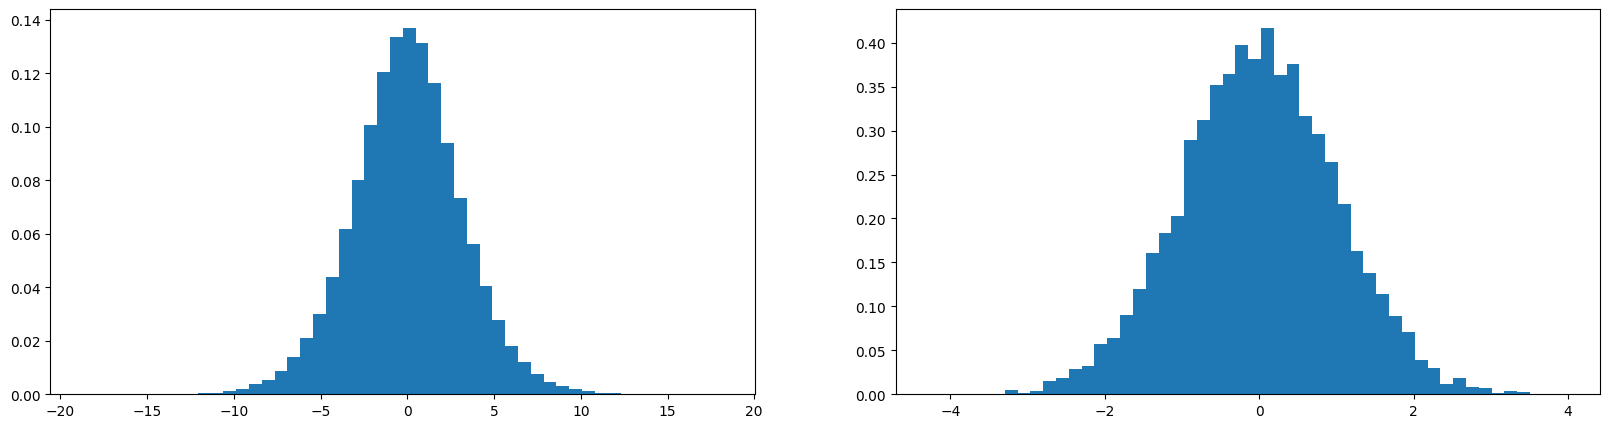

In [39]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(y.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(x.view(-1).tolist(), 50, density=True)

In [40]:
lri = []
lossi = []
stepi = []

In [41]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1 # (32, 200)

  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  ## track status
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.3102
  10000/ 200000: 2.2824
  20000/ 200000: 2.2800
  30000/ 200000: 2.0824
  40000/ 200000: 2.1360
  50000/ 200000: 2.1656
  60000/ 200000: 2.3270
  70000/ 200000: 2.3075
  80000/ 200000: 2.0548
  90000/ 200000: 2.0544
 100000/ 200000: 2.0242
 110000/ 200000: 2.0284
 120000/ 200000: 1.9702
 130000/ 200000: 2.1005
 140000/ 200000: 2.1739
 150000/ 200000: 2.1115
 160000/ 200000: 1.7135
 170000/ 200000: 1.9933
 180000/ 200000: 1.8169
 190000/ 200000: 2.3476


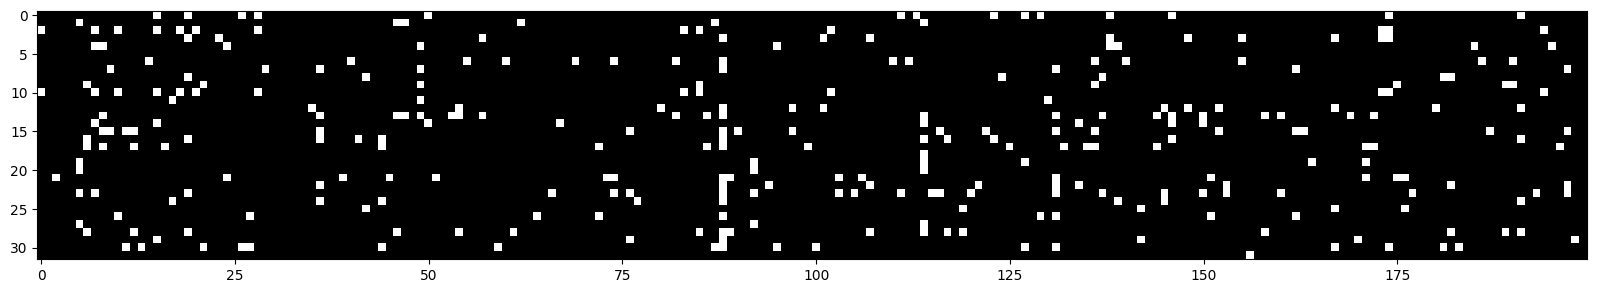

In [42]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

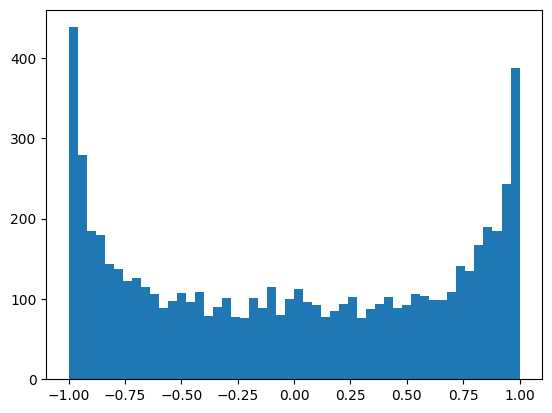

In [43]:
plt.hist(h.view(-1).tolist(), 50);

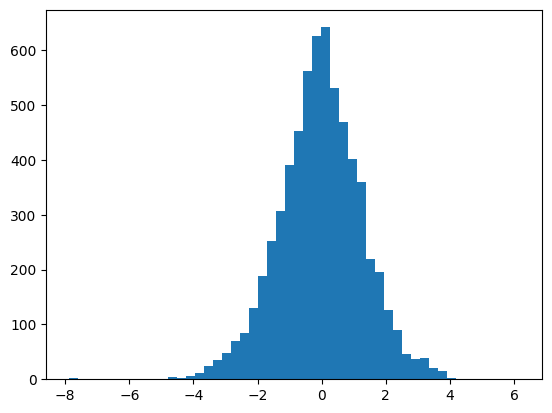

In [44]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [45]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

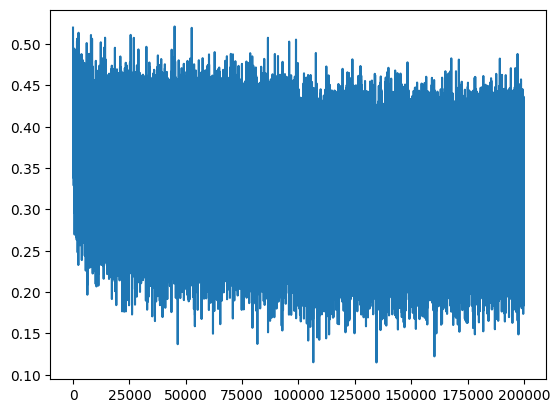

In [46]:
plt.plot(torch.arange(200000), torch.tensor(lossi))

In [48]:
## calibrate the batch norm at the end of the training

with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  ## measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [49]:
@torch.no_grad()
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  return loss.item()

split_loss('train')
split_loss('val')

train 2.068892478942871
val 2.1086833477020264


2.1086833477020264